In [1]:
%pip install icecream

In [2]:
import torch
import torch.nn.functional as F
import torchvision

import pathlib
import PIL
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from icecream import ic

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [3]:
!git clone https://github.com/haroldlkh/school_image_datasets.git

Cloning into 'school_image_datasets'...
remote: Enumerating objects: 5859, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 5859 (delta 0), reused 3 (delta 0), pack-reused 5856
Receiving objects: 100% (5859/5859), 1.46 GiB | 30.88 MiB/s, done.
Checking out files: 100% (5849/5849), done.


In [4]:
# Resize and change to tensor and create image dataset
img_size=128
resize = torchvision.transforms.Resize((img_size, img_size))
to_tensor = torchvision.transforms.ToTensor()
transform = torchvision.transforms.Compose([resize, to_tensor])

ds = torchvision.datasets.ImageFolder("/content/school_image_datasets/data607/plant_diseases", transform=transform)

dl = torch.utils.data.DataLoader(ds, batch_size=len(ds))

In [5]:
#Change data to X and y getting all the data into memory.
# This is necessary to run most SKLearn models as very few algorithms are compatible with incremental learning.
X, y = next(iter(dl))
#print(X[0])

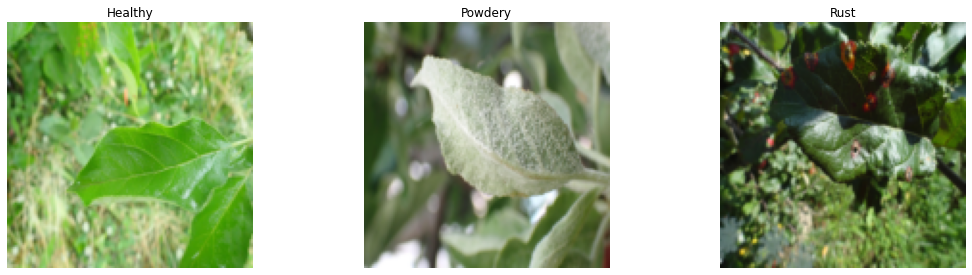

In [ ]:
# Visualize an example of each class

labels_map = {
    0: "Healthy",
    1: "Powdery",
    2: "Rust"
}


# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels_map))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels_map):
    idx = list(np.array(y)).index(label)
    ax.imshow(torch.moveaxis(X[idx], 0, -1))
    ax.axis('off')
    ax.set_title(labels_map[label])

#### Randomly split dataset into train and test sets

In [6]:
# Randomly split data into train and test sets
from sklearn.model_selection import train_test_split
 
X_tr, X_te, y_tr, y_te = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)
print(X_tr.shape)


torch.Size([1225, 3, 128, 128])


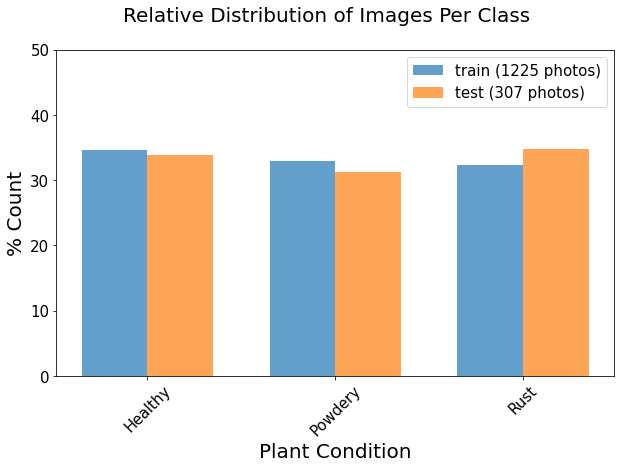

In [ ]:
# Check distribution of images between train and test sets
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    labels_map = {
    0: "Healthy",
    1: "Powdery",
    2: "Rust"
    } 

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% Count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))

    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, labels_map.values(), rotation=45, size=15)
    plt.yticks(size=15)
    plt.xlabel('Plant Condition', size=20)
    plt.ylabel(ylabel_text, size=20)

fig = plt.gcf()
fig.set_size_inches(10,6) 
plt.suptitle('Relative Distribution of Images Per Class', size=20)
plot_bar(y_tr, loc='left')
plot_bar(y_te, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_tr)), 
    'test ({0} photos)'.format(len(y_te))
], prop={'size': 15});
plt.ylim(0, 50);

plt.show()

In [7]:
# Preprocessing
# Normalize the data 
mean = torch.mean(X_tr, dim=[0, 2, 3])
std = torch.std(X_tr, dim=[0, 2, 3])
print(mean, std)
normalizer = torchvision.transforms.Normalize(mean, std)

# Normalize and reshape X training and testing variables

# Un-Normalized 
X_train = np.array(X_tr).reshape(-1, 128*128*3)  # Unnormalized training set
X_test = np.array(X_te).reshape(-1, 128*128*3)  # Unnormalized testing set
X_prepared = np.array(X.reshape(-1, 128*128*3))

# Normalized Versions
X_train_prepared = np.array(normalizer(X_tr)).reshape(-1, 128*128*3)
X_test_prepared = np.array(normalizer(X_te)).reshape(-1, 128*128*3)

# Reshape y variables
y_prepared = np.array(y)
y_train = np.array(y_tr)
y_test = np.array(y_te)

tensor([0.4699, 0.5886, 0.3983]) tensor([0.1847, 0.1678, 0.1931])


### Naive Bayes Classifier

In [ ]:
NB_clf = GaussianNB()
NB_clf.fit(X_train_prepared, y_train)
acc_tr = np.mean(y_train == NB_clf.predict(X_train_prepared))
acc_te = np.mean(y_test == NB_clf.predict(X_test_prepared))
print('Training Accuracy: {:.2f}, Testing Accuracy: {:.2f}'.format(acc_tr, acc_te))

Training Accuracy: 0.74, Testing Accuracy: 0.69


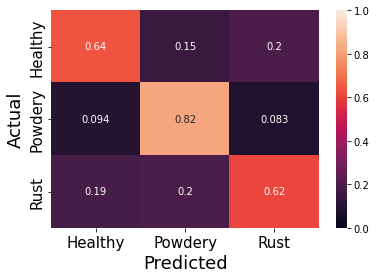

In [ ]:
# Compute the confusion matrix
NB_clf = GaussianNB()
NB_clf.fit(X_train_prepared, y_train)
y_pred = NB_clf.predict(X_test_prepared)

NB_cmx = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    normalize='true')
target_names = ['Healthy', 'Powdery', 'Rust']

sns.heatmap(NB_cmx, annot=True, xticklabels=target_names, yticklabels=target_names,
            vmin=0, vmax=1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Actual', fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.show()

In [ ]:
# With 5-fold cross-validation
NB_clf = make_pipeline(StandardScaler(), GaussianNB())
scores = cross_val_score(NB_clf, X_prepared, y_prepared, cv=5)
print('Cross Validation Testing Accuracy: {:.2f}'.format(np.mean(scores)))

Cross Validation Testing Accuracy: 0.68


### SGD Classifier

#### Model with default parameters

In [ ]:
# Model Training
SGD_clf = SGDClassifier(max_iter=1000, tol=1e-3)
SGD_clf.fit(X_train_prepared, y_train)

# Model Testing
y_pred = SGD_clf.predict(X_test_prepared)
acc_tr = np.mean(y_train == SGD_clf.predict(X_train_prepared))
acc_te = np.mean(y_test == y_pred)

print('Training Accuracy: {:.2f}, Testing Accuracy: {:.2f}'.format(acc_tr, acc_te))
    

Training Accuracy: 1.00, Testing Accuracy: 0.72


In [ ]:
# Grid Search for Best Parameters
params = {
    "loss" : ["hinge", "log"],
    "alpha" : [0.0001, 0.001],
    "penalty" : ["l2", "l1", "elasticnet"],
}

SGD_clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(SGD_clf, param_grid=params, cv=5, verbose=10)


grid.fit(X_train_prepared, y_train)

print(grid.best_params_) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START alpha=0.0001, loss=hinge, penalty=l2.......................
[CV 1/5; 1/12] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.743 total time=  12.5s
[CV 2/5; 1/12] START alpha=0.0001, loss=hinge, penalty=l2.......................
[CV 2/5; 1/12] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.739 total time=  15.2s
[CV 3/5; 1/12] START alpha=0.0001, loss=hinge, penalty=l2.......................
[CV 3/5; 1/12] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.829 total time=  14.0s
[CV 4/5; 1/12] START alpha=0.0001, loss=hinge, penalty=l2.......................
[CV 4/5; 1/12] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.722 total time=  15.7s
[CV 5/5; 1/12] START alpha=0.0001, loss=hinge, penalty=l2.......................
[CV 5/5; 1/12] END alpha=0.0001, loss=hinge, penalty=l2;, score=0.788 total time=  12.6s
[CV 1/5; 2/12] START alpha=0.0001, loss=hinge, penalty=l1.......................
[CV 1/5;

In [ ]:
# Best params
print(grid.best_params_)

{'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}


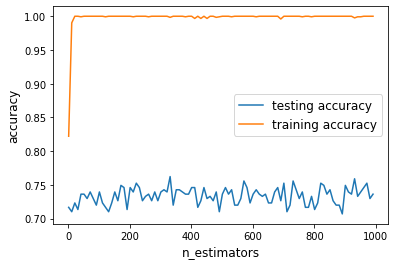

In [ ]:
# Estimating number of maximum iterations 
ks = np.arange(1, 1001, 10)
accs_tr = []
accs_te = []
for k in tqdm(ks):
  model = SGDClassifier(max_iter=k, alpha=0.0001, loss='hinge', penalty='l2')
  model.fit(X_train_prepared, y_train)
  acc_tr = np.mean(y_train == model.predict(X_train_prepared))
  accs_tr.append(acc_tr)
  acc_te = np.mean(y_test == model.predict(X_test_prepared))
  accs_te.append(acc_te)

accs_tr = np.array(accs_tr)
accs_te = np.array(accs_te)

plt.plot(ks, accs_te, label="testing accuracy")
plt.plot(ks, accs_tr, label="training accuracy")
plt.xlabel("n_estimators", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend(loc="center right", fontsize=12)
plt.show()

In [ ]:
# Fitting best params
SGD_clf = SGDClassifier(max_iter=200, alpha=0.0001, loss='hinge', penalty='l2')
SGD_clf.fit(X_train_prepared, y_train)
y_pred = SGD_clf.predict(X_test_prepared)
acc_te = np.mean(y_test == y_pred)
print('Testing Accuracy: {:.2f}'.format(acc_te))

Testing Accuracy: 0.73


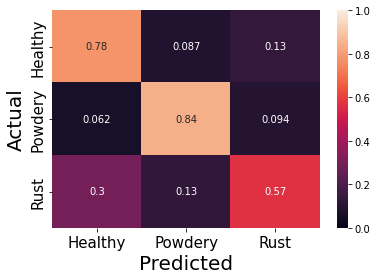

In [ ]:
# Compute the confusion matrix with the best parameters from the grid search
SGD_clf = SGDClassifier(max_iter = 200, alpha=0.0001, loss='hinge', penalty='l2')
SGD_clf.fit(X_train_prepared, y_train)
y_pred = SGD_clf.predict(X_test_prepared)
sgd_cmx = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    normalize='true')

target_names = ['Healthy', 'Powdery', 'Rust']

sns.heatmap(sgd_cmx, annot=True, xticklabels=target_names, yticklabels=target_names,
            vmin=0, vmax=1)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylabel('Actual', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.show()

In [ ]:
# With 5-fold cross-validation
SGD_clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter = 200, alpha=0.0001, loss='hinge', penalty='l2'))
scores = cross_val_score(SGD_clf, X_prepared, y_prepared, cv=5)
print('Cross Validation Testing Accuracy: {:.2f}'.format(np.mean(scores)))

Cross Validation Testing Accuracy: 0.70


### Random Forest Classifier
We fit the model to non-normalized image data as normalization is not required for tree based models. 

  0%|          | 0/100 [00:00<?, ?it/s]

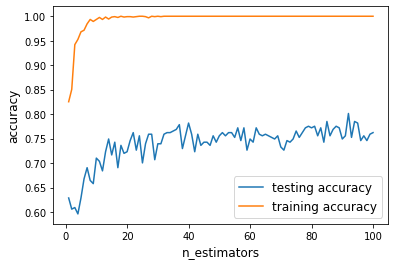

In [ ]:
# Checking the effect of the number of estimators on prediction accuracy
ks = np.arange(1, 101)
accs_tr = []
accs_te = []
for k in tqdm(ks):
  model = RandomForestClassifier(n_estimators=k)
  model.fit(X_train, y_train)
  acc_tr = np.mean(y_train == model.predict(X_train))
  accs_tr.append(acc_tr)
  acc_te = np.mean(y_test == model.predict(X_test))
  accs_te.append(acc_te)

accs_tr = np.array(accs_tr)
accs_te = np.array(accs_te)

plt.plot(ks, accs_te, label="testing accuracy")
plt.plot(ks, accs_tr, label="training accuracy")
plt.xlabel("n_estimators", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.show()

In [ ]:
# With 100 estimators
RF_clf = RandomForestClassifier(n_estimators=100)
RF_clf.fit(X_train, y_train)
acc_tr = np.mean(y_train == RF_clf.predict(X_train))
acc_te = np.mean(y_test == RF_clf.predict(X_test))
print('Training Accuracy: {:.2f}, Testing Accuracy: {:.2f}'.format(acc_tr, acc_te))

Training Accuracy: 1.00, Testing Accuracy: 0.75


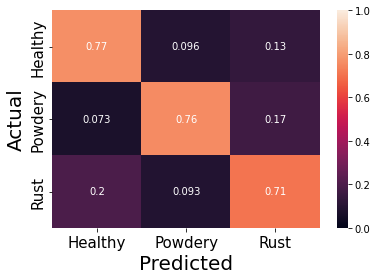

In [ ]:
# Compute the confusion matrix
y_pred = RF_clf.predict(X_test)
RF_cmx = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    normalize='true')
target_names = ['Healthy', 'Powdery', 'Rust']

sns.heatmap(RF_cmx, annot=True, xticklabels=target_names, yticklabels=target_names,
            vmin=0, vmax=1)
plt.ylabel('Actual', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [ ]:
# With 5-fold cross-validation (Feature Scaling not required)
RF_clf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(RF_clf, X_prepared, y_prepared, cv=5)
print('Cross Validation Testing Accuracy: {:.2f}'.format(np.mean(scores)))

Cross Validation Testing Accuracy: 0.75


### Gradient Boosting Classifier

In [ ]:
GB_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
GB_clf.fit(X_train, y_train)
acc_tr = np.mean(y_train == GB_clf.predict(X_train))
acc_te = np.mean(y_test == GB_clf.predict(X_test))
print('Testing Accuracy: {:.2f}'.format(acc_te))

Testing Accuracy: 0.74


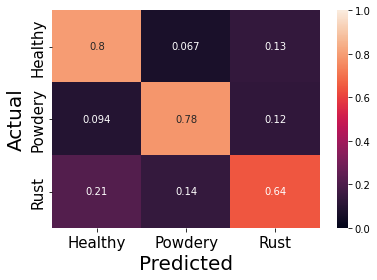

In [ ]:
# Compute the confusion matrix
y_pred = GB_clf.predict(X_test)

GB_cmx = confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    normalize='true')
target_names = ['Healthy', 'Powdery', 'Rust']

sns.heatmap(GB_cmx, annot=True, xticklabels=target_names, yticklabels=target_names,
            vmin=0, vmax=1)
plt.ylabel('Actual', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

In [8]:
# With 5-fold cross-validation (Scaling not required)
GB_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
scores = cross_val_score(GB_clf, X_prepared, y_prepared, cv=5)
print('Cross Validation Testing Accuracy: {:.2f}'.format(np.mean(scores)))

Cross Validation Testing Accuracy: 0.73
